In [5]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import scipy
import pickle as pkl
import h5py
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import style
from imagenet_classes import lab_dict
import sklearn
import pandas as pd
import stats
import scipy.misc
sys.path.append('/accounts/projects/vision/chandan/max_activation_interpretation_pytorch/')
import max_act
from model_helpers import Model_feats
import visualize_ims as viz
from visualize_ims import im_to_np, get_im

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

# get data on labs, preds, and feats

In [3]:
out_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/cnns_preds'
print(sorted(os.listdir(out_dir)))

# labs_train slightly smaller because part of last batch gets cut off
labs_train = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_train'])
labs_val = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_val'])

['.ipynb_checkpoints', 'alexnet.h5', 'alexnet_corrs.h5', 'alexnet_feats.h5', 'densenet121_corrs.h5', 'densenet169.h5', 'densenet169_corrs.h5', 'densenet169_feats.h5', 'densenet201_corrs.h5', 'ind_tops_train.pkl', 'ind_tops_train_corrs.pkl', 'ind_tops_val.pkl', 'ind_tops_val_corrs.pkl', 'labs.h5', 'readme.md', 'resnet101_corrs.h5', 'resnet152_corrs.h5', 'resnet18.h5', 'resnet18_corrs.h5', 'resnet18_feats.h5', 'resnet34_corrs.h5', 'resnet50.h5', 'resnet50_corrs.h5', 'vgg11.h5', 'vgg11_corrs.h5', 'vgg11_feats.h5', 'vgg13.h5', 'vgg13_corrs.h5', 'vgg13_feats.h5', 'vgg16.h5', 'vgg16_corrs.h5', 'vgg19.h5', 'vgg19_corrs.h5']


**hist correct points top pred vs hist wrong points top pred**

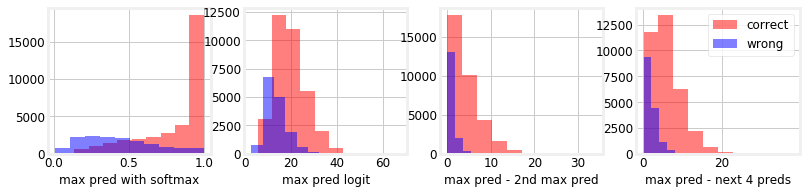

In [4]:
# params to set
preds = np.array(h5py.File(oj(out_dir, 'vgg11.h5'), 'r')['preds_val'])
labs = labs_val

# find right idxs
preds_max_class = np.argmax(preds, axis=1)
idxs_correct = preds_max_class == labs
preds = np.sort(preds, axis=1) # sort into ascending order for each row


R, C = 1, 4
plt.figure(figsize=(C * 3, R * 2.5))
preds_max = np.max(scipy.special.softmax(preds, axis=1), axis=1) #[:, -1]
plt.subplot(R, C, 1)
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5)
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5)
plt.xlabel('max pred with softmax')

plt.subplot(R, C, 2)
preds_max = preds[:, -1]
plt.xlabel('max pred logit')
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5, label='correct')
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5, label='wrong')

plt.subplot(R, C, 3)
preds_max = preds[:, -1] - preds[:, -2]
plt.xlabel('max pred - 2nd max pred')
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5, label='correct')
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5, label='wrong')

plt.subplot(R, C, 4)
preds_max = preds[:, -1] - (preds[:, -2] + preds[:, -3] + preds[:, -4] + preds[:, -5]) / 4
plt.xlabel('max pred - next 4 preds')
plt.hist(preds_max[idxs_correct], color='red', alpha=0.5, label='correct')
plt.hist(preds_max[~idxs_correct], color='blue', alpha=0.5, label='wrong')
plt.legend()
plt.show()

# look at features

In [12]:
# n x feat_size
feats_train = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_train']
feats_val = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

(50000, 4096)

In [13]:
sims = metrics.pairwise.cosine_similarity(feats_val[:10000])
print(sims.shape)

(10000, 10000)


In [ ]:
plt.figure(figsize=(14, 14))
plt.imshow(sims, interpolation=None)
plt.grid(False)
plt.savefig('act_sims.pdf')
plt.show()

In [10]:
means = np.mean(feats_val, axis=0)
stds = np.std(feats_val, axis=0)

In [ ]:
sns.heatmap(feats_val[:10, :4096])
plt.show()

In [14]:
print(feats_val.shape)

(50000, 4096)


# look at individual ims

In [3]:
root = '/scratch/users/vision/data/cv/imagenet_full'
dset_name = 'val/val' # train or val/val
dset_val = dset.ImageFolder(oj(root, dset_name), 
                            transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor()]))

# find closest nn point

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [127]:
m = models.alexnet(pretrained=True).eval()
class_num = 130 # 84 is peacock, 130 is flamingo
offset = 50 * class_num
im_num = offset + 3

im_np, im_torch = get_im(dset_val, im_num)
# show(im_np)
# pred = m(im_torch) # this matches what's in preds

search within class for neighbors

In [128]:
preds = np.array(h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_val'])
feats = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

feats_all = np.array(feats[offset: offset + 50])
feats_im = np.array(feats[im_num])

preds_all = np.array(preds[offset: offset + 50])
preds_im = np.array(preds[im_num])

In [129]:
# dists = feats_all @ feats_im.T # dot prods
dists = np.linalg.norm(feats_all - feats_im, axis=1, ord=2) # l2 dists
# dists = np.linalg.norm(preds_all - preds_im, axis=1, ord=2) # l2 dist in prediction
inds_sorted = np.argsort(dists) # increasing

In [ ]:
ranks = np.arange(dists.size)
inds_correct = np.argmax(preds_all[inds_sorted], axis=1) == class_num
plt.plot(ranks[inds_correct][1:], dists[inds_sorted][inds_correct][1:], 'o', label='correct')
plt.plot(ranks[~inds_correct], dists[inds_sorted][~inds_correct], 'o', label='wrong')
plt.legend()
plt.xlabel('rank of closest match')
plt.ylabel('dist')
plt.show()

In [ ]:
ims_np = []
for j in range(6):
#     plt.subplot(1, 6, j + 1)
    im_np, im_torch = get_im(dset_val, offset + inds_sorted[j])
    ims_np.append(im_np)
#     show(im_np)
# plt.show()
viz.show(ims_np)
plt.show()

# max act
also was comparing sgd vs adam

In [ ]:
device = 'cuda'
m = m.to(device)
center_crop = None
# output_weights = -1 * torch.ones(1000).to(device)
output_weights = torch.zeros(1000).to(device)
output_weights[130] = 1 # 84 is peacock, 130 is flamingo
ims_opt, losses = max_act.maximize_im(model=m, im_shape=im1_torch.shape, 
                                      output_weights=output_weights, 
                                      lambda_tv=1e-2, lambda_pnorm=1e-2, jitter=0,
                                      device=device, num_iters=300, 
                                      init='zero', lr=1e-2, center_crop=center_crop)

In [ ]:
plt.subplot(121)
plt.plot(losses, '.-')
plt.ylabel('dist')
plt.xlabel('iter')
plt.subplot(122)
plt.hist(im_to_np(ims_opt[-1]).flatten())
plt.show()

viz.show([im_to_np(im) for im in ims_opt], dpi=40)
plt.show()

In [ ]:
viz.show(im_to_np(ims_opt[-1]))

# maximize diff between 2 ims

In [ ]:
im1_np, im1_torch = get_im(dset_val, offset + inds_sorted[0])
im2_np, im2_torch = get_im(dset_val, offset + inds_sorted[1])
feats1 = feats[offset + inds_sorted[0]]
feats2 = feats[offset + inds_sorted[1]]

In [ ]:
viz.show([im1_np, im2_np])
plt.show()

In [273]:
m = models.alexnet(pretrained=True).eval().to('cuda')
model_feats = Model_feats(m, model_name='alexnet', feat_size=4096)

In [ ]:
ims_opt, losses = max_act.maximize_im(model=model_feats, im_shape=im1_torch.shape, 
                                      objective='diff', im1 = im1_torch, im2=im2_torch,
                                      lambda_tv=5e-1, lambda_pnorm=5e-1, jitter=0,
                                      device=device, num_iters=900, 
                                      init='zero', lr=1e-3, center_crop=None)

In [ ]:
plt.subplot(121)
plt.plot(losses, '.-')
plt.ylabel('dist')
plt.xlabel('iter')
plt.subplot(122)
plt.hist(im_to_np(ims_opt[-1]).flatten())
plt.show()

# im_opt = ims_opt[-1]
viz.show([im_to_np(im1_torch), im2_np, im_to_np(im_opt), 
      im_to_np(im_opt - im2_torch), im_to_np(im_opt - im1_torch)], dpi=40)
plt.show()
viz.show([im_to_np(im) for im in ims_opt], dpi=40)
plt.show()

In [ ]:
viz.show(im_to_np(ims_opt[-1]))